==============TEAM.GANADA=============

###DATA.LOAD()###

In [266]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import statsmodels.api as sm
import scipy.stats
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from scipy.stats import skew
from scipy.stats import spearmanr
from PIL import Image
from IPython.display import Image, display
from sklearn.cluster import KMeans

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

SEED = 2
np.random.seed(SEED)

- 혹시 모르니 일단 뭐든 다 불러와봅니다.

In [267]:
PATH = '/home/june/VisualStudio'

train=pd.read_csv('/home/june/VisualStudio/train.csv', encoding='utf-8')
test=pd.read_csv('/home/june/VisualStudio/test.csv', encoding='utf-8')
submission=pd.read_csv('/home/june/VisualStudio/sample_submission.csv')

- 경로를 설정합니다.

In [268]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sun', 'cooling', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sun', 'cooling', 'solar']


- 킹세종의 위대한 한글이지만 인코더 앞에선 나약하기에 영어로 바꿔줍니다.

In [269]:
train = pd.read_csv(PATH + '/train.csv', encoding='utf-8', names=train_col, header=0)
test = pd.read_csv(PATH + '/test.csv', encoding='utf-8', names=test_col, header=0)
sub = pd.read_csv(PATH + '/sample_submission.csv', encoding='utf-8')

- euc-kr인코더는 택도 없었습니다. 

In [270]:
train.head()

,num,date_time,target,temp,wind,humid,rain,sun,cooling,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0,0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0,0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0,0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0,0


In [271]:
test.head()

,num,date_time,temp,wind,humid,rain,sun,cooling,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 칼럼feature들이 영어로 잘 바뀌었습니다.

###EDA()###

In [272]:
train[['num', 'cooling','solar']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'cooling']
    hot[count]=train.loc[i,'solar']

for i in range(len(test)):
    test.loc[i, 'cooling']=ice[test['num'][i]]
    test.loc[i, 'solar']=hot[test['num'][i]]

def time(x):
    return int(x[-2:])
train['time']=train['date_time'].apply(lambda x: time(x))
test['time']=test['date_time'].apply(lambda x: time(x))

In [273]:
def make_time(train):

    train['date_time'] = pd.to_datetime(train.date_time)
    train['month'] = train.date_time.dt.month                    
    train['day'] = train.date_time.dt.day                        
    train['hour'] = train.date_time.dt.hour                
    train['weekday'] = train.date_time.dt.weekday               
    train['dayofyear'] = train.date_time.dt.dayofyear           
    
    return train

train = make_time(train)
test = make_time(test)

In [274]:
train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

- 주말 휴무일 다 합쳐서 그냥 ‘holiday’로 통일했습니다.

- 주말 포함 쉬는 날은 ‘holiday’컬럼에서 1번, 평일은 0입니다.

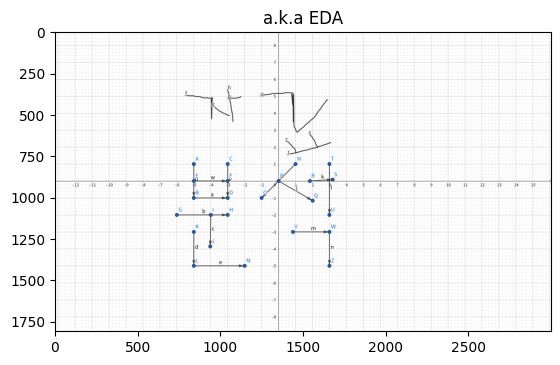

In [275]:
DTBS = mpimg.imread('/home/june/바탕화면' + '/geogebra-export.png')

DTBSplot = plt.imshow(DTBS)
plt.title('a.k.a EDA')
plt.imshow(DTBS)

###df.interpolate()###

In [276]:
for i in range(1, 61):
    test.loc[test.num == i, 'cooling'] = train.loc[train.num == i, 'cooling'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

test[['temp', 'wind', 'humid', 'rain', 'sun']] = test[['temp', 'wind', 'humid', 'rain', 'sun']].interpolate(method='values').round(1)

In [277]:
train.head()

,num,date_time,target,temp,wind,humid,rain,sun,cooling,solar,time,month,day,hour,weekday,dayofyear,holiday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,0,6,1,0,0,153,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,1,6,1,1,0,153,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,2,6,1,2,0,153,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,3,6,1,3,0,153,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,4,6,1,4,0,153,0.0


In [278]:
test.head()

,num,date_time,temp,wind,humid,rain,sun,cooling,solar,time,month,day,hour,weekday,dayofyear,holiday
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0,0,8,25,0,1,238,0.0
1,1,2020-08-25 01:00:00,27.6,1.4,75.3,0.0,0.0,0.0,0.0,1,8,25,1,1,238,0.0
2,1,2020-08-25 02:00:00,27.5,1.2,76.7,0.0,0.0,0.0,0.0,2,8,25,2,1,238,0.0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,0.0,0.0,0.0,0.0,3,8,25,3,1,238,0.0
4,1,2020-08-25 04:00:00,26.9,1.2,79.7,0.0,0.0,0.0,0.0,4,8,25,4,1,238,0.0


NaN값은  너굴맨이 처리했다구!!


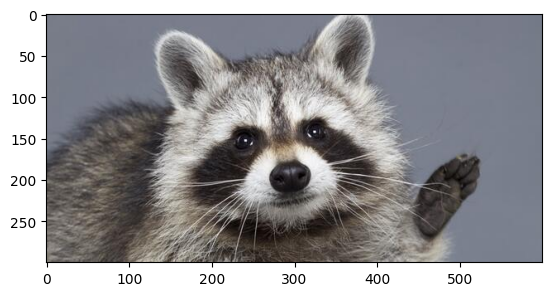

In [303]:
ngman = mpimg.imread('/home/june/바탕화면/neogul.jpeg')
ngmanplot = plt.imshow(ngman)
plt.imshow(ngman)

print("NaN값은  너굴맨이 처리했다구!!")

###weather.visualize()###

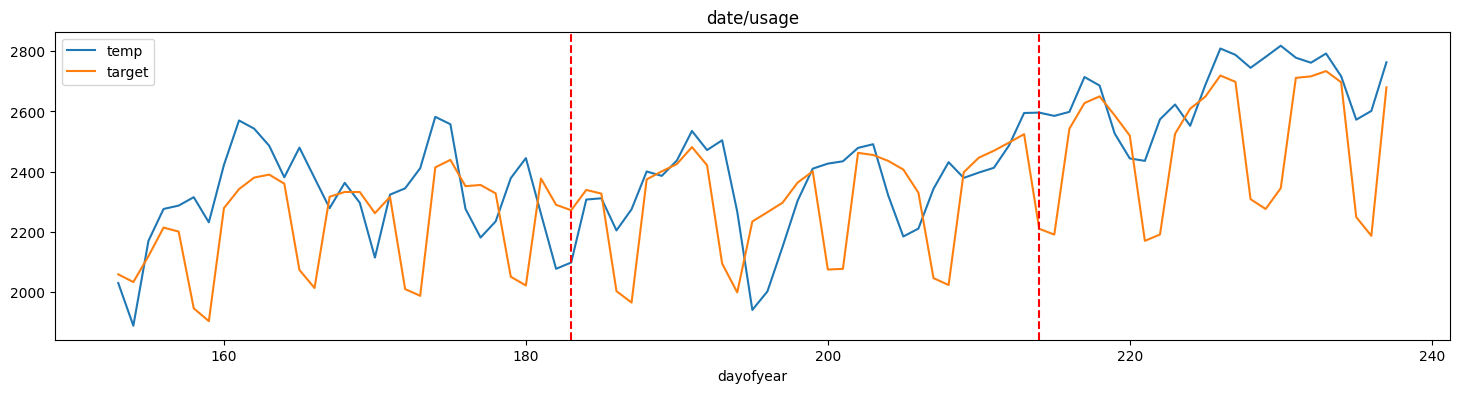

In [280]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('date/usage')
plt.show()

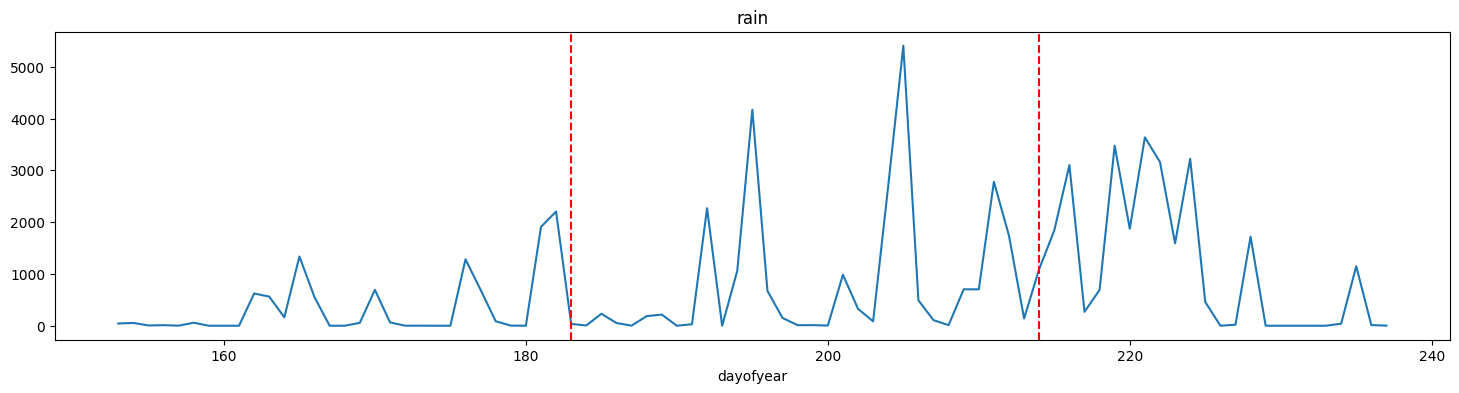

In [281]:
(train.groupby(['dayofyear'])['rain'].sum()).plot(figsize=(18, 4))
plt.title('rain')
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.show()

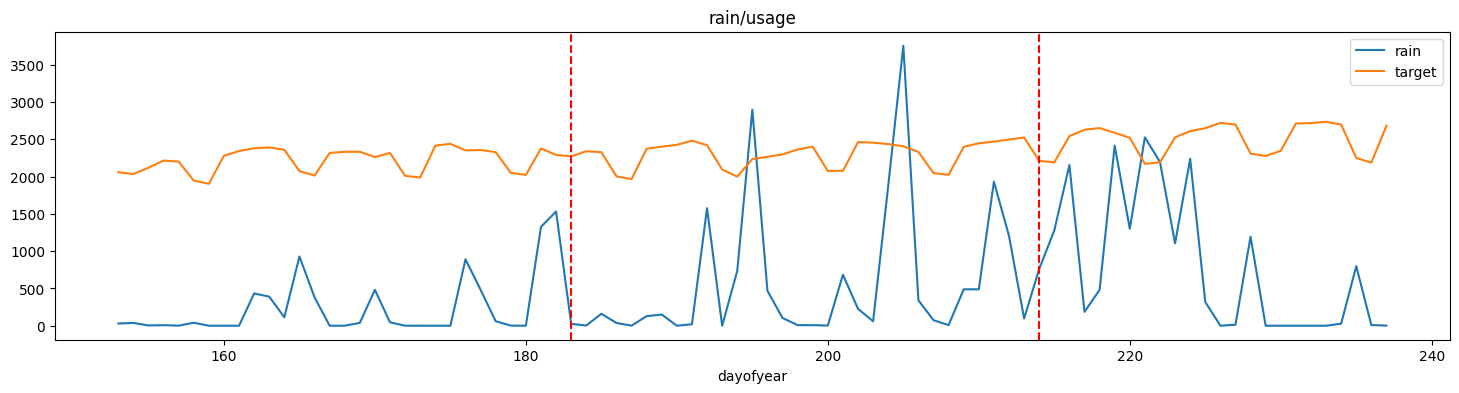

In [282]:
(train.groupby(['dayofyear'])['rain'].mean()*1000).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['rain', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('rain/usage')
plt.show()


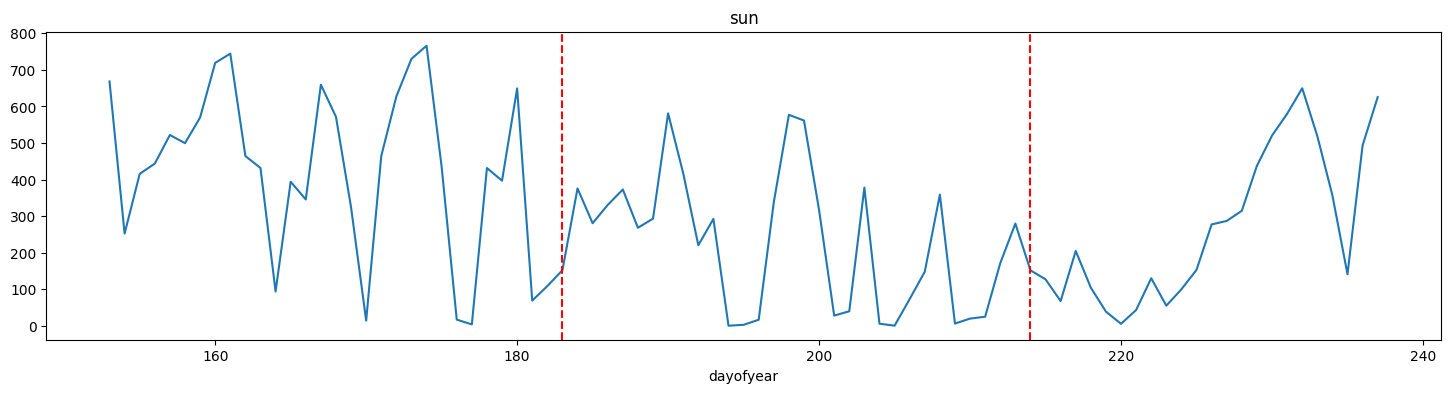

In [283]:
train.groupby(['dayofyear'])['sun'].sum().plot(figsize=(18, 4))
plt.title('sun')
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.show()

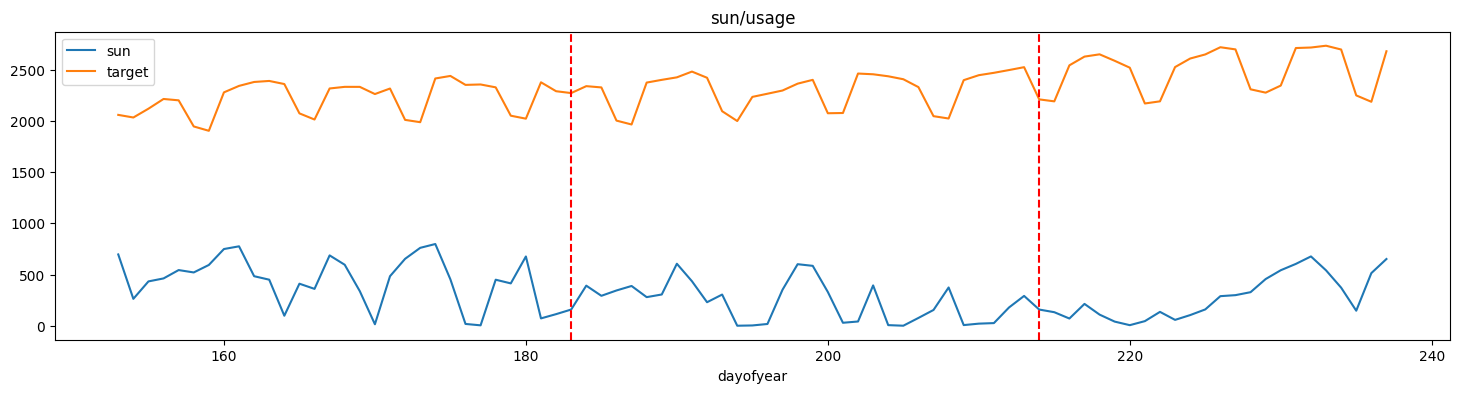

In [284]:
(train.groupby(['dayofyear'])['sun'].mean()*1500).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['sun', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('sun/usage')
plt.show()


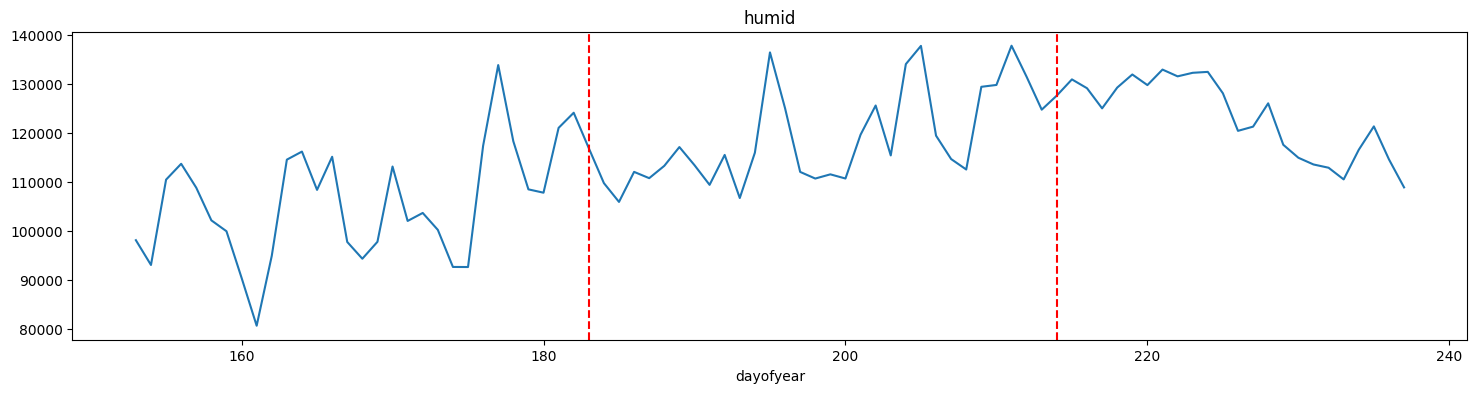

In [285]:
train.groupby(['dayofyear'])['humid'].sum().plot(figsize=(18, 4))
plt.title('humid')
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.show()

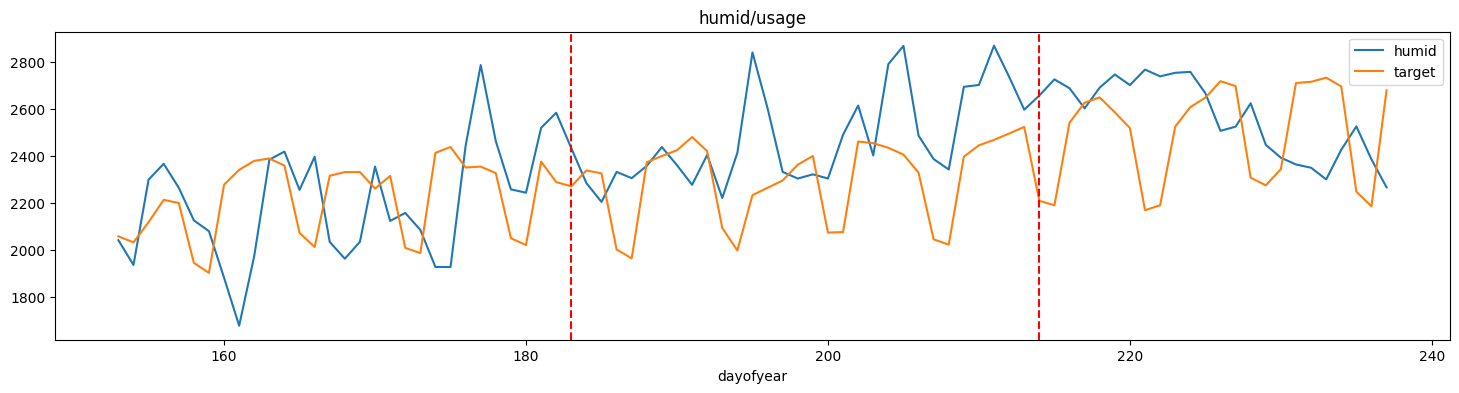

In [286]:
(train.groupby(['dayofyear'])['humid'].mean()*30).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['humid', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('humid/usage')
plt.show()

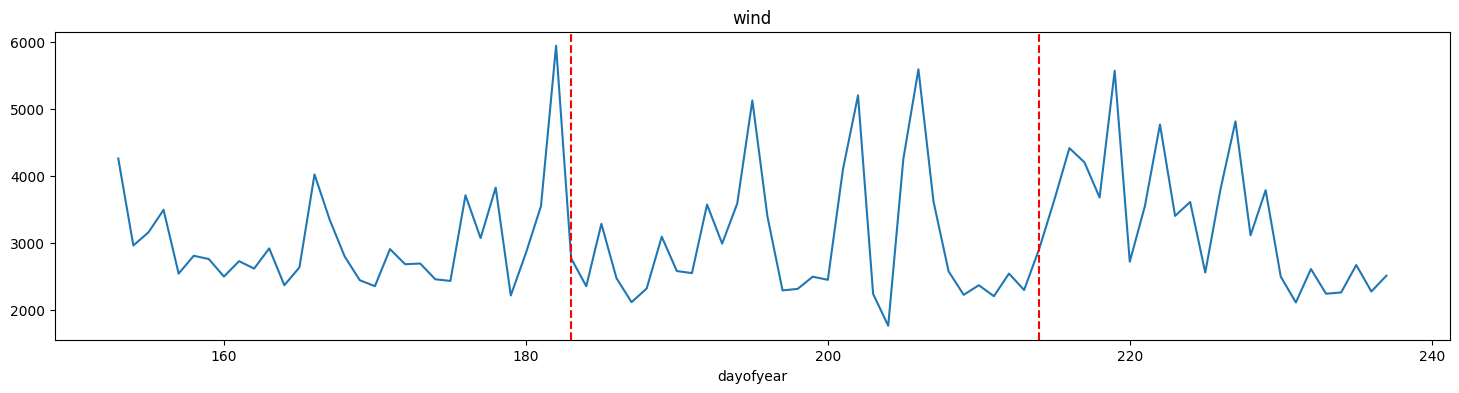

In [287]:
train.groupby(['dayofyear'])['wind'].sum().plot(figsize=(18, 4))
plt.title('wind')
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.show()

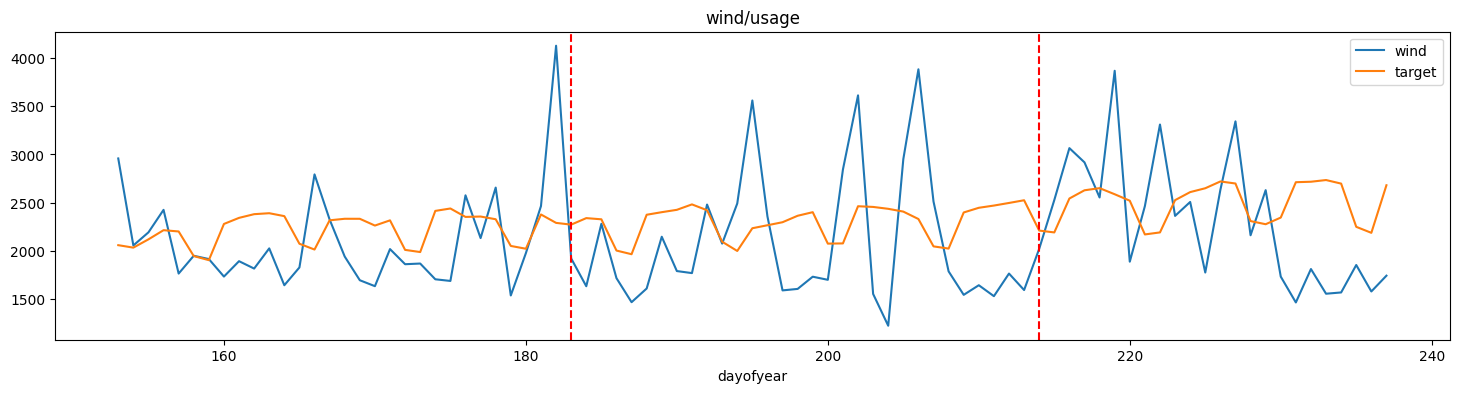

In [288]:
(train.groupby(['dayofyear'])['wind'].mean()*1000).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['wind', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('wind/usage')
plt.show()

###cluster.visualize()###

In [289]:
eda_df = train.copy()

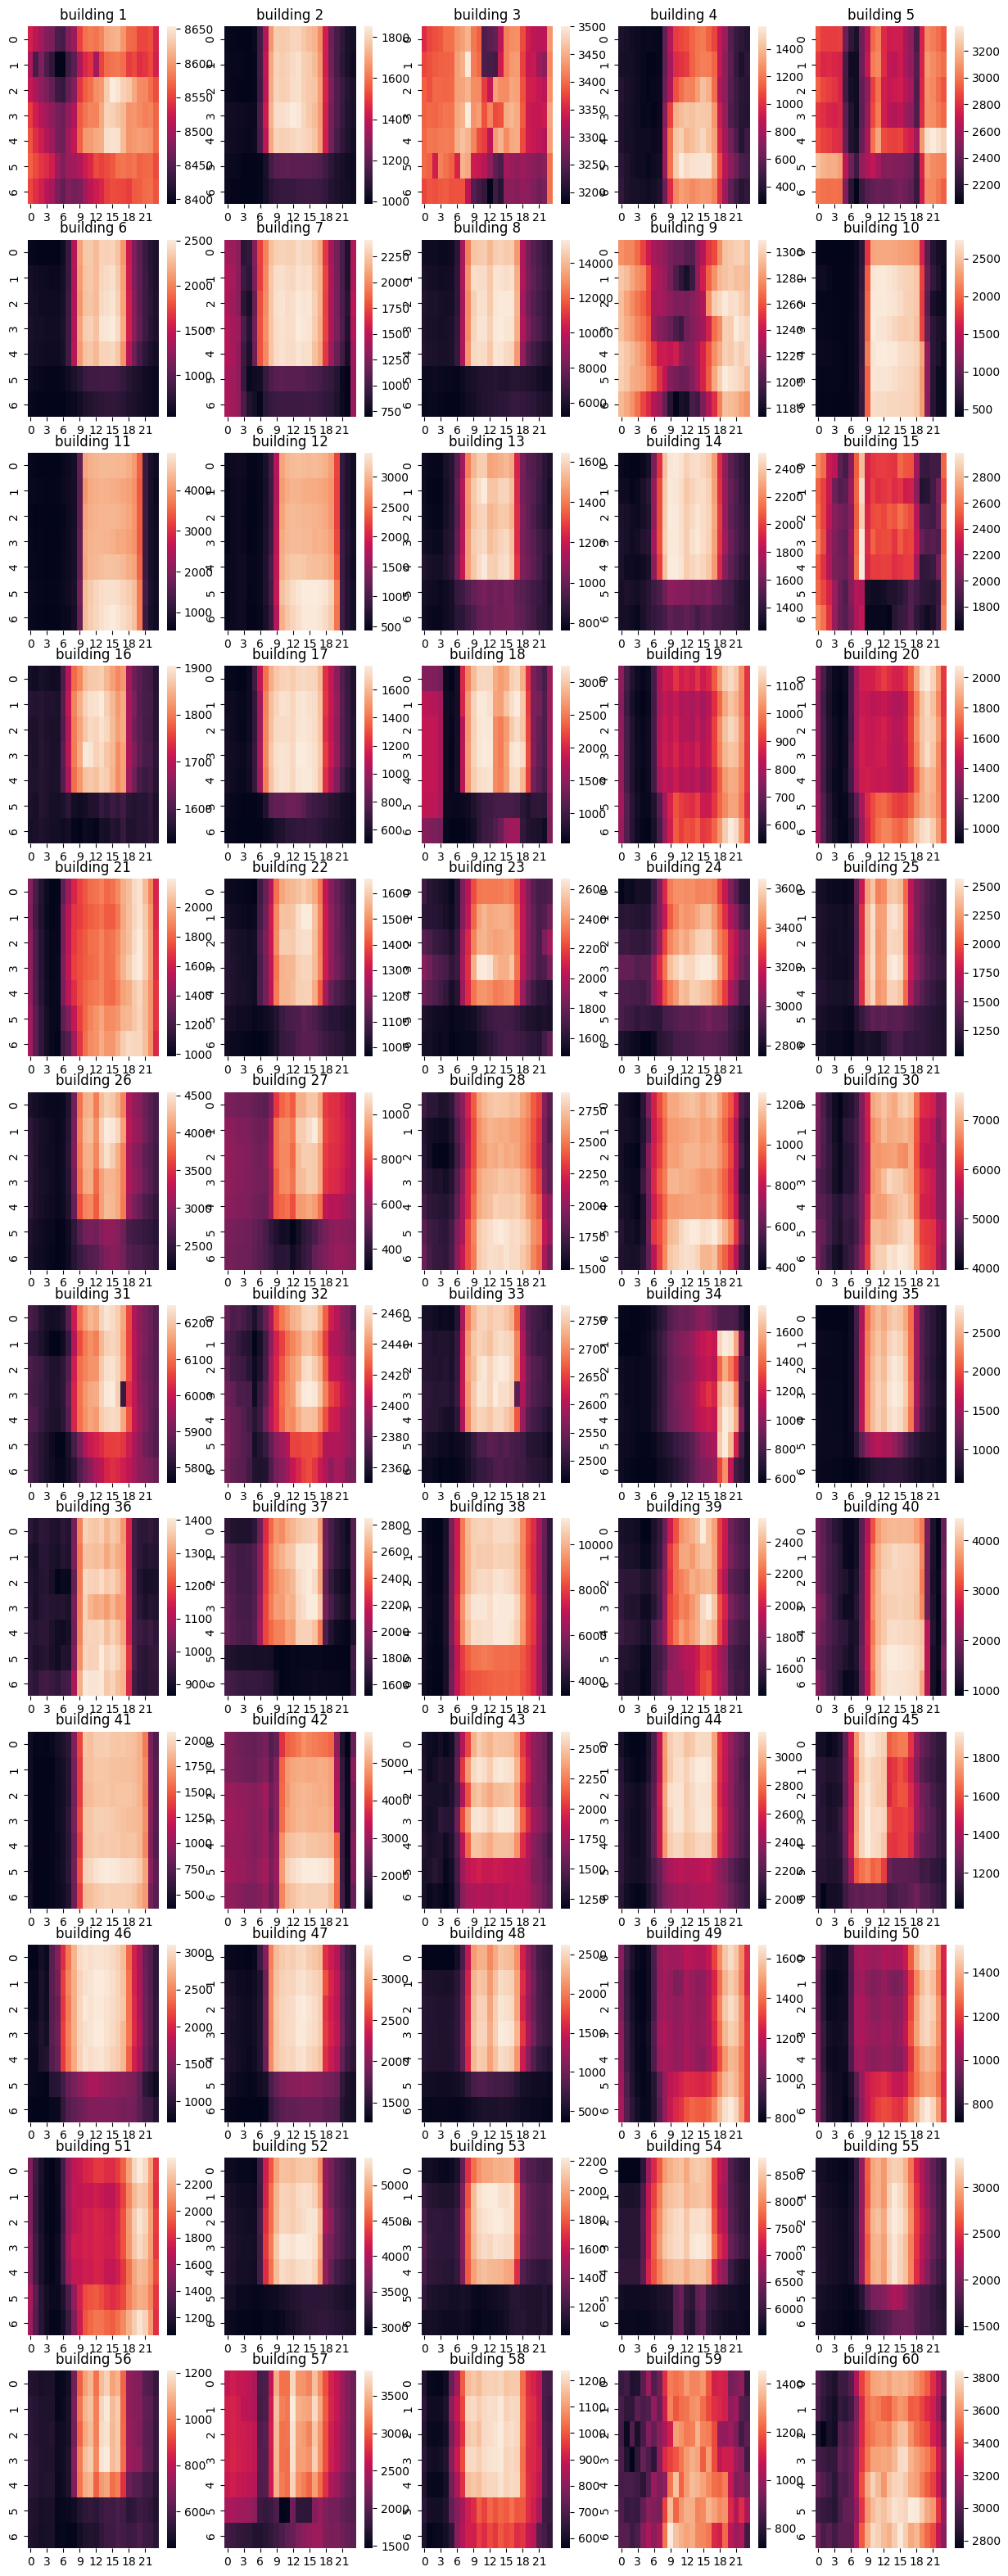

In [290]:
fig = plt.figure(figsize = (15, 40))
for num in eda_df['num'].unique():
    df = eda_df[eda_df.num == num]
    df = df.groupby(['weekday', 'hour'])['target'].mean().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(12, 5, num)
    sns.heatmap(df)
    plt.title(f'building {num}')
    plt.xlabel('')
    plt.ylabel('')


In [291]:
by_weekday = eda_df.groupby(['num','weekday'])['target'].median().reset_index().pivot('num','weekday','target').reset_index()
by_hour = eda_df.groupby(['num','hour'])['target'].median().reset_index().pivot('num','hour','target').reset_index().drop('num', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['num'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

- 건물을 기준으로 하는 데이터프레임을 생성합니다.

In [292]:
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

- 전력사용량이 아닌 요일과 시간대에 따른 전력 사용량의 경향성에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요합니다.

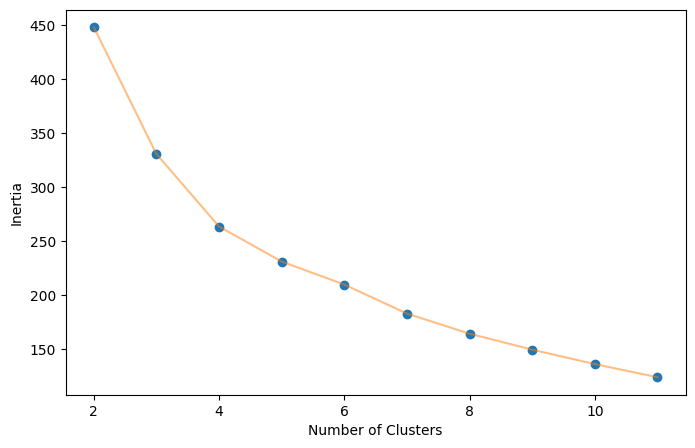

In [293]:

def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

- Elbow Method란 군집분석(특히, KMeans 분석)에서 군집수를 결정하는 방법으로 군집수에 따라 군집내 총 제곱합 (WSS : Within cluster Sum of Squares) 플롯팅하여 팔꿈치의 위치을 일반적으로 적절한 군집 수으로 선택하는 방법임.

- 엘보 메쏘드에 의거 군집수는 4로 정했습니다

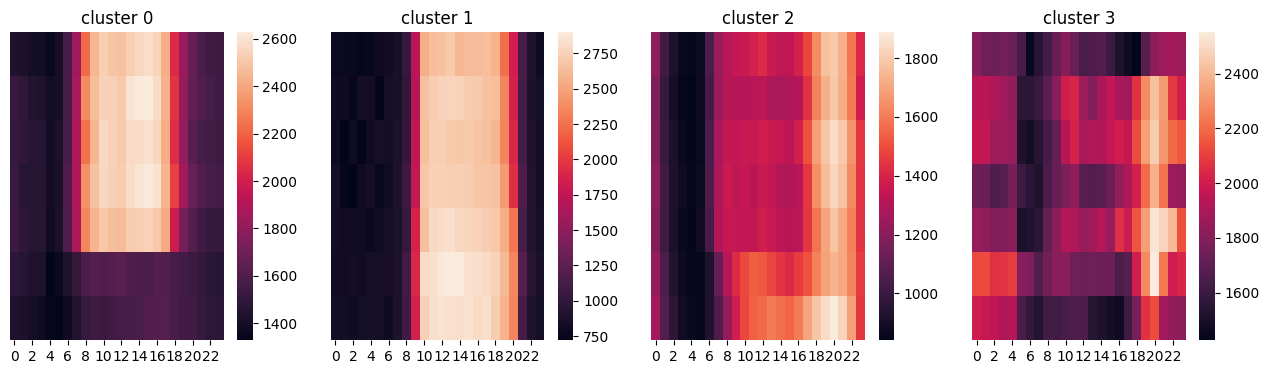

In [294]:
eda_df = eda_df.merge(df_clust[['num','km_cluster']], on = 'num', how = 'left')

fig = plt.figure(figsize = (20, 4))
for c in range(4):
    temp = eda_df[eda_df.km_cluster == c]
    temp = temp.groupby(['weekday', 'hour'])['target'].median().reset_index().pivot('weekday', 'hour', 'target')
    plt.subplot(1, 5, c+1)
    sns.heatmap(temp)
    plt.title(f'cluster {c}')
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

- 첫번째 군집은 평일 오전7시부터 전력 사용량이 증가해 저녁6시까지 사용량이 많은 패턴으로 주말에는 쉬는걸 보아하니 가장 쉽게 떠올릴 수 있는 건물 유형으로 사무실이나 학교가 있습니다.

- 두번째 군집은 시간별 사용량 패턴이 매우 뚜렷한데 주말 상관없이 사용량이 비슷하며 특히 금,토,일 저녁시간에 사용량이 평소보다 조금 더 많은 것으로 보아 카페, 식당 PC 방 등이 위치해있는 상가라고 생각됩니다.

- 세번째 군집은 평일 보다 주말 낮 시간대에 사용량이 비교적 많고 특히 낮보다 밤 시간대에 사용량이 많은것으로 보아 술집이 많은 건물이라 예측해볼 수 있습니다.

- 네번째 군집은 패턴이 매우 자유분방합니다. 제일 많이 사용하는 시간대는 화,수,목,금,토 저녁 시간인데 사실 어떤 유형인지 파악이 쉽지 않습니다. 다양한 업종이 섞여있는 건물로 추정합니다.

In [295]:
# dictionary mapping cluster and building
match = df_clust[['num','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(60):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

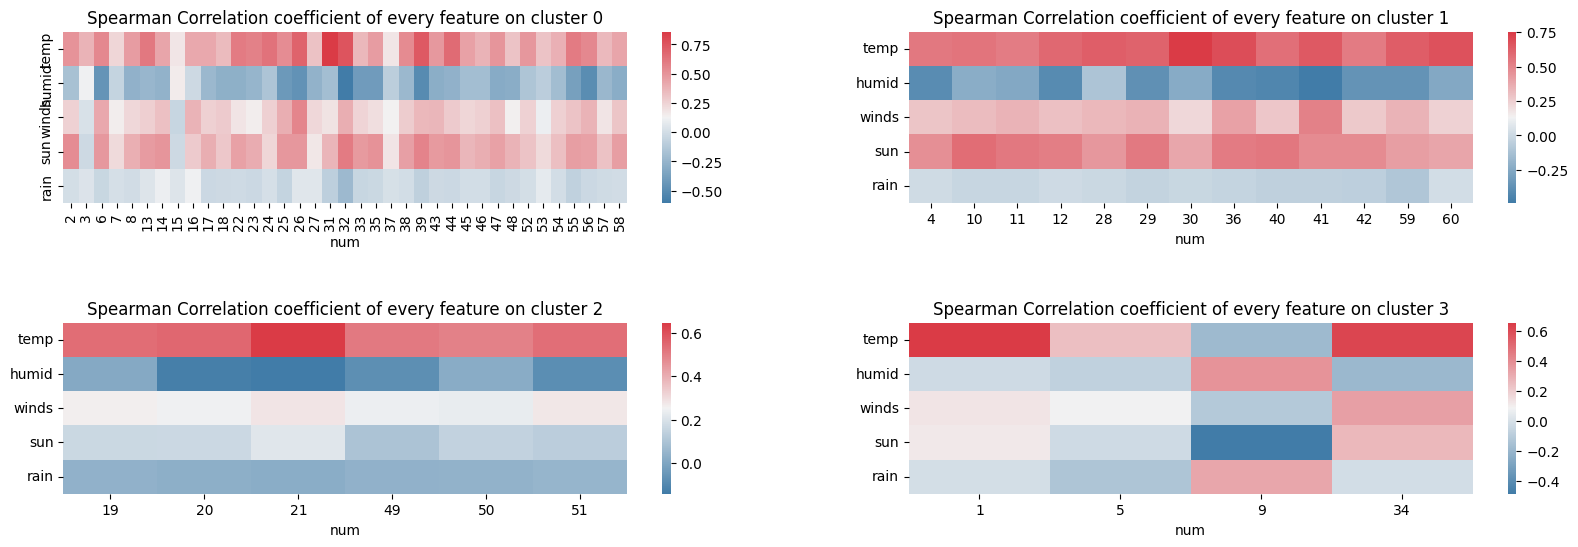

In [296]:
# cluster 0
df_0 = eda_df[eda_df.km_cluster == 0]
df = df_0.groupby(['num','date_time'])['temp','humid','wind','sun','rain','target'].mean().reset_index()
corrs_0 = []
for num in clust_to_num[0]:
    corr = []
    corr.append(num)
    for feat in ['temp','humid','wind','sun','rain']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_0.append(corr)
# cluster 1
df_1 = eda_df[eda_df.km_cluster == 1]
df = df_1.groupby(['num','date_time'])['temp','humid','wind','sun','rain','target'].mean().reset_index()
corrs_1 = []
for num in clust_to_num[1]:
    corr = []
    corr.append(num)
    for feat in ['temp','humid','wind','sun','rain']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_1.append(corr)
# cluster 2
df_2 = eda_df[eda_df.km_cluster == 2]
df = df_2.groupby(['num','date_time'])['temp','humid','wind','sun','rain','target'].mean().reset_index()
corrs_2 = []
for num in clust_to_num[2]:
    corr = []
    corr.append(num)
    for feat in ['temp','humid','wind','sun','rain']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_2.append(corr)
# cluster 3
df_3 = eda_df[eda_df.km_cluster == 3]
df = df_3.groupby(['num','date_time'])['temp','humid','wind','sun','rain','target'].mean().reset_index()
corrs_3 = []
for num in clust_to_num[3]:
    corr = []
    corr.append(num)
    for feat in ['temp','humid','wind','sun','rain']:
        corr.append(spearmanr(df.loc[df.num == num, feat], df.loc[df.num == num, 'target']).correlation)
    corrs_3.append(corr)
corrs_total = [corrs_0, corrs_1, corrs_2, corrs_3]

fig = plt.figure(figsize = (20, 6))
for i, corrs in enumerate(corrs_total):    
    corr_df = pd.DataFrame(np.array(corrs), columns = ['num','temp','humid','winds','sun','rain'])
    corr_df['num'] = corr_df['num'].astype(int)
    corr_df = corr_df.set_index('num')

    plt.subplot(2,2,i+1)
    sns.heatmap(corr_df.transpose(), cmap=sns.diverging_palette(240,10,as_cmap=True))
    plt.subplots_adjust(hspace = 0.7)
    plt.title(f'Spearman Correlation coefficient of every feature on cluster {i}')

- 군집들과 기후요인들을 복합적으로 살펴봅시다.

- 사무실 학교 등으로 추정되는 첫번째 군집에서는 온도, 일조량과 비례하는 경향을 보입니다.
- 상업시설이 많은 두번째 그룹에서는 온도에 영향을 가장 크게 받는것 같습니다.
- 저녁 및 밤에 특히 사용량이 활발한 세번째 클러스터는 거의 온도에만 영향을 받는것 같습니다.
- 자유분방한 사용량을 보여줬던 네번째 군집은 역시 영향을 받는 기후 요인 패턴도 자유분방 합니다만 여전히 과반수 이상은 온도에 영향을 받는것 같습니다.

- 생각보다 일조량이 미치는 영향이 큰 것 같습니다.

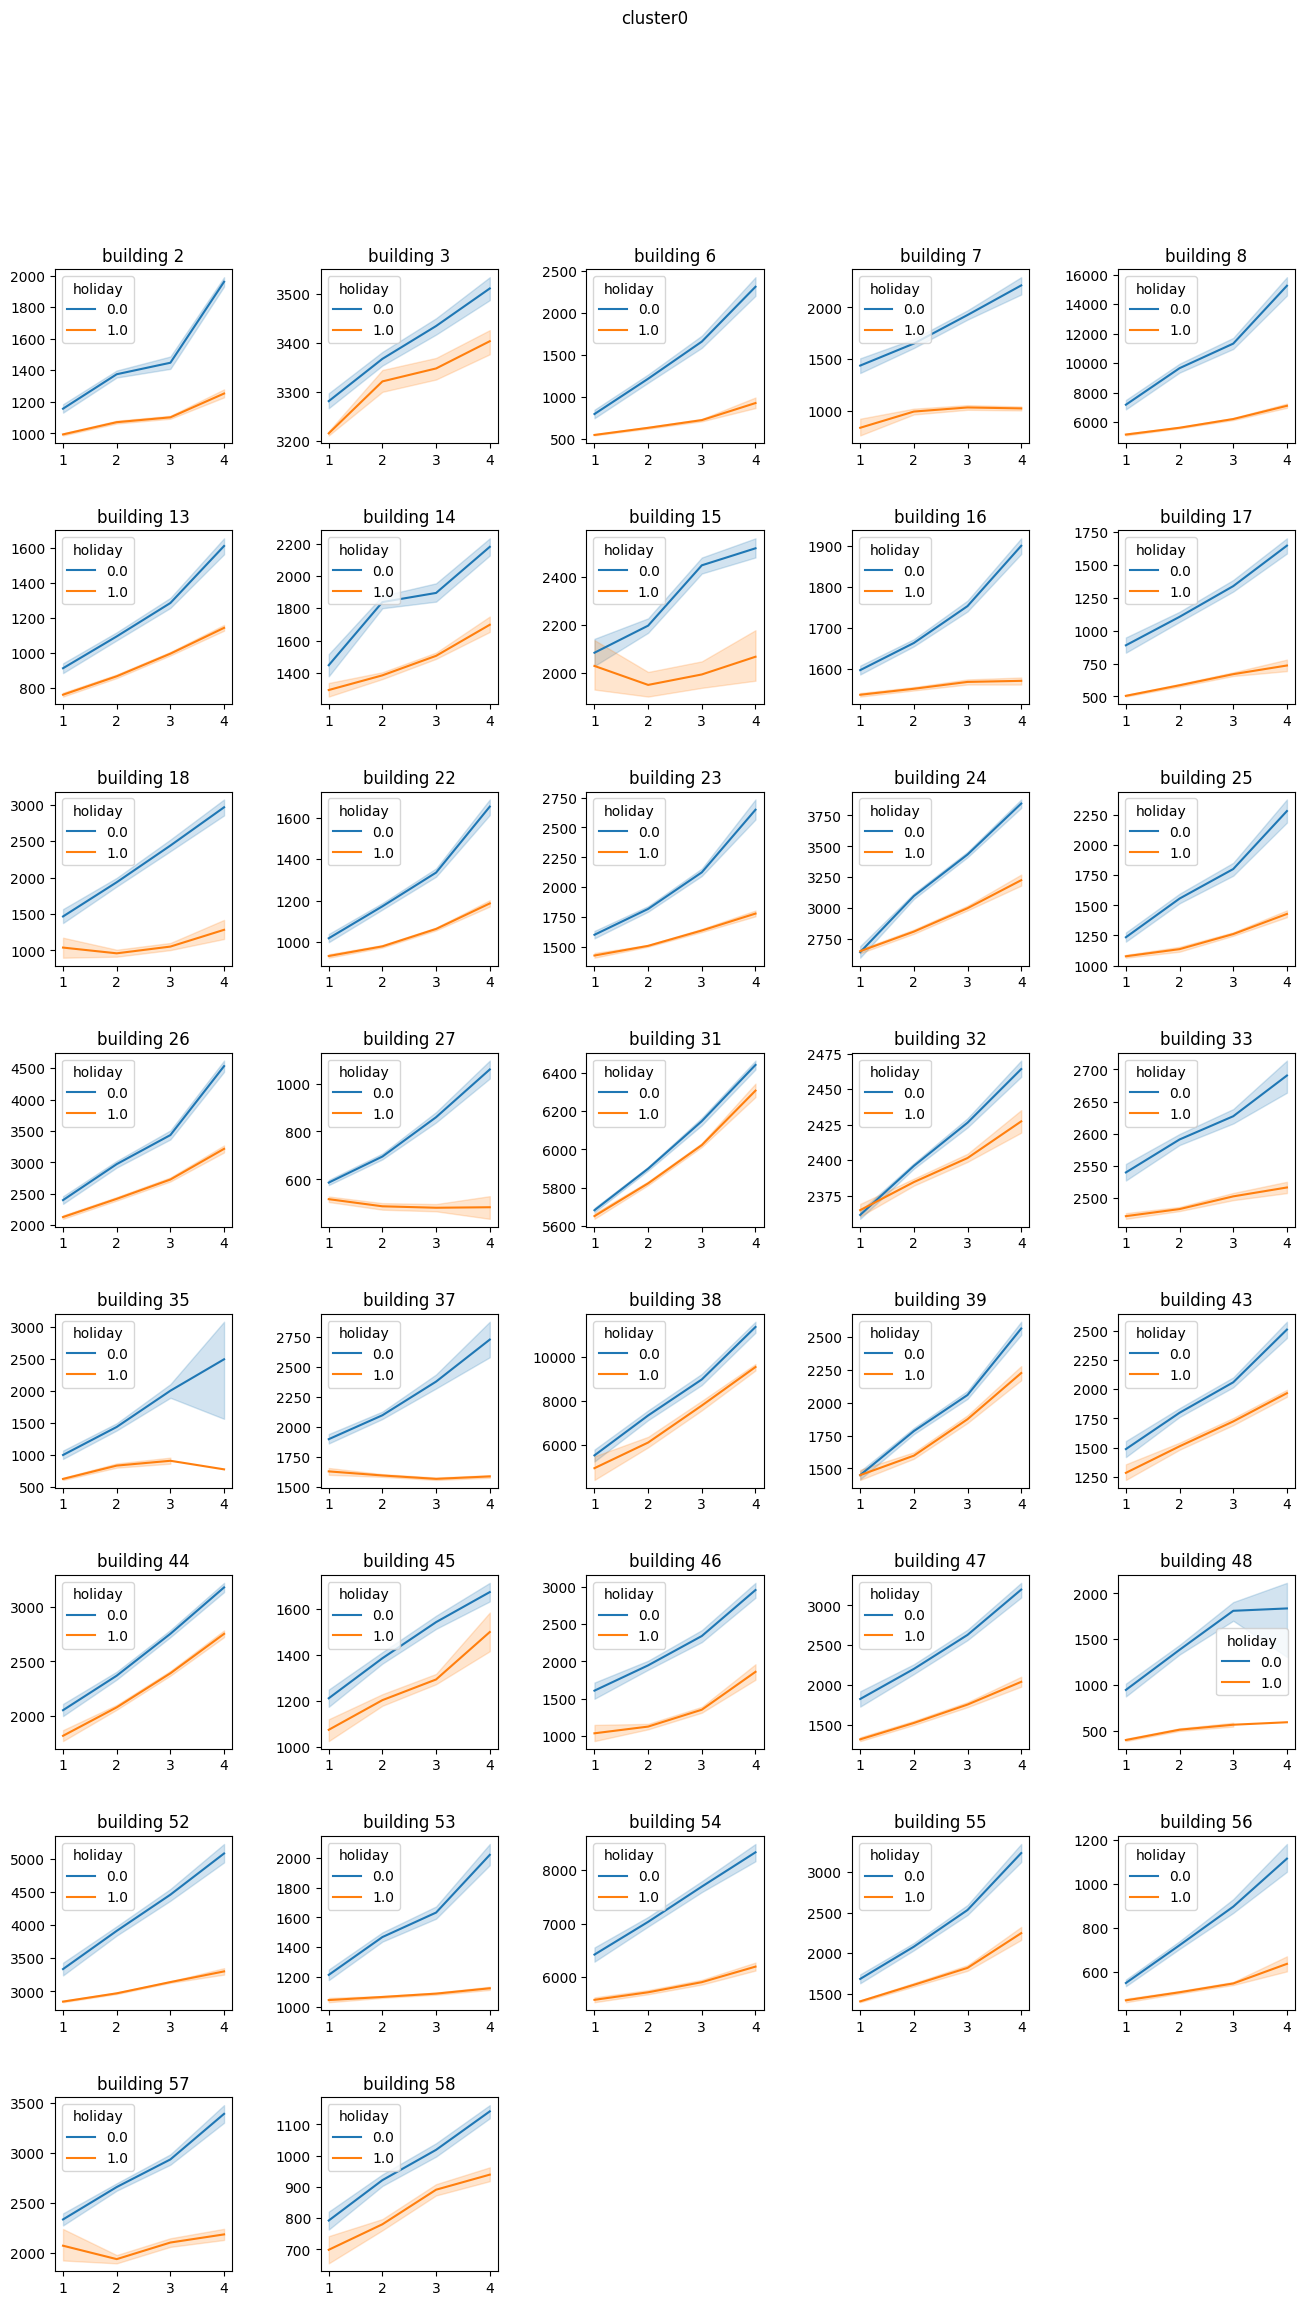

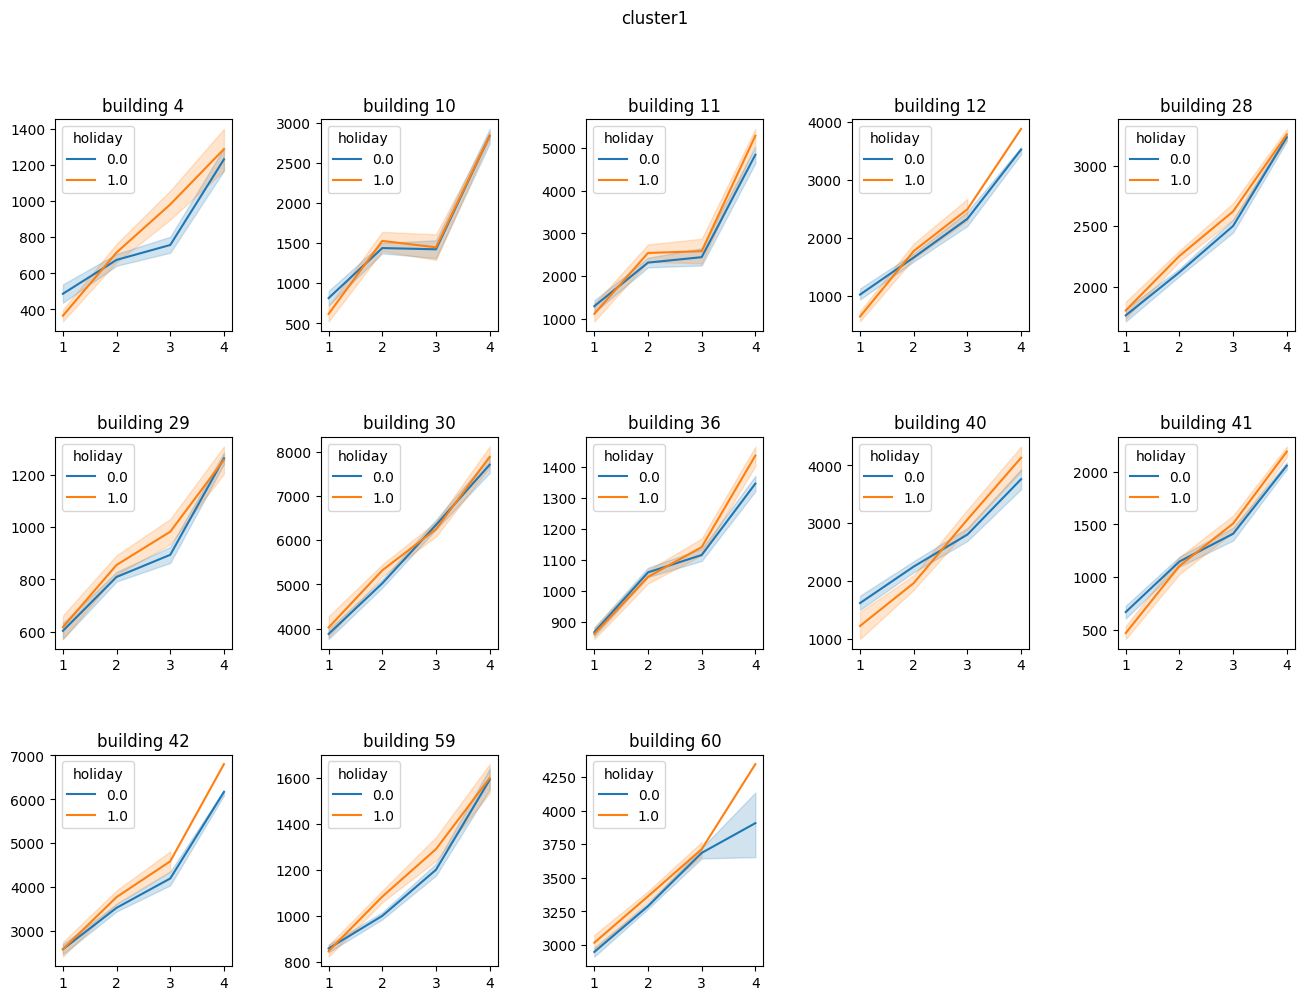

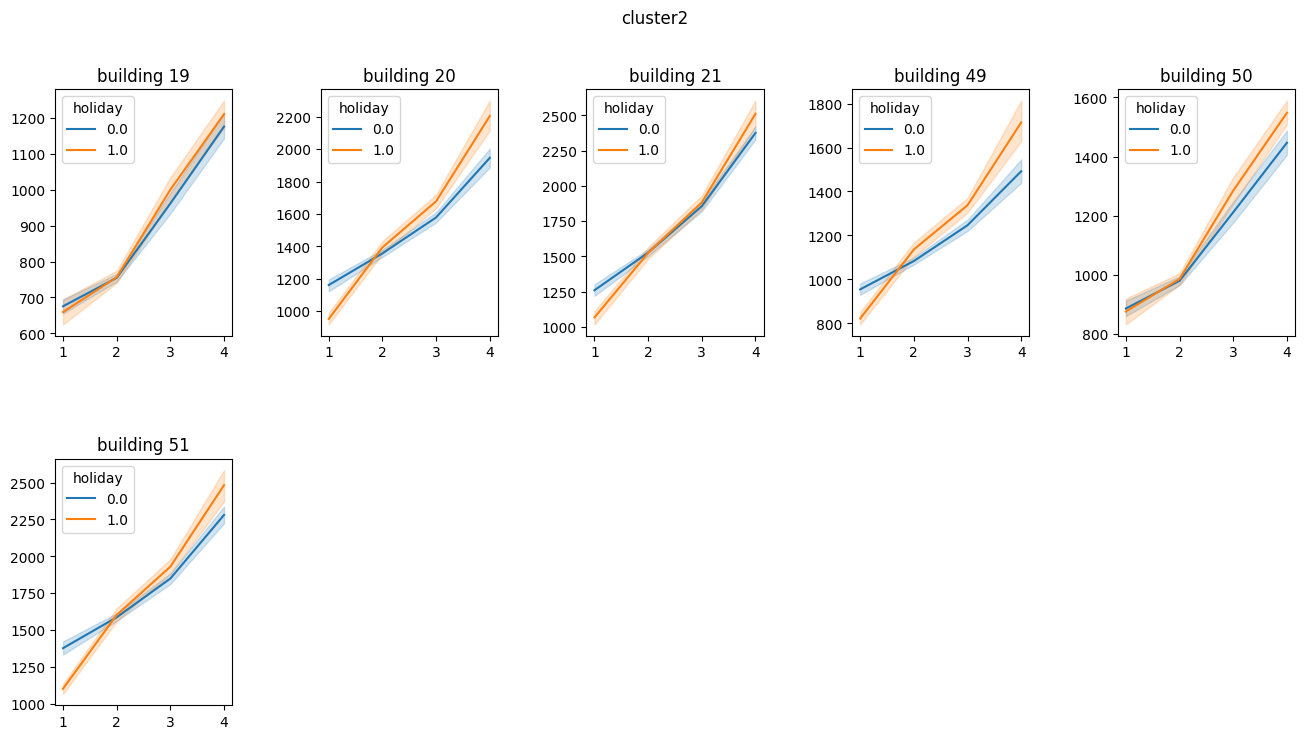

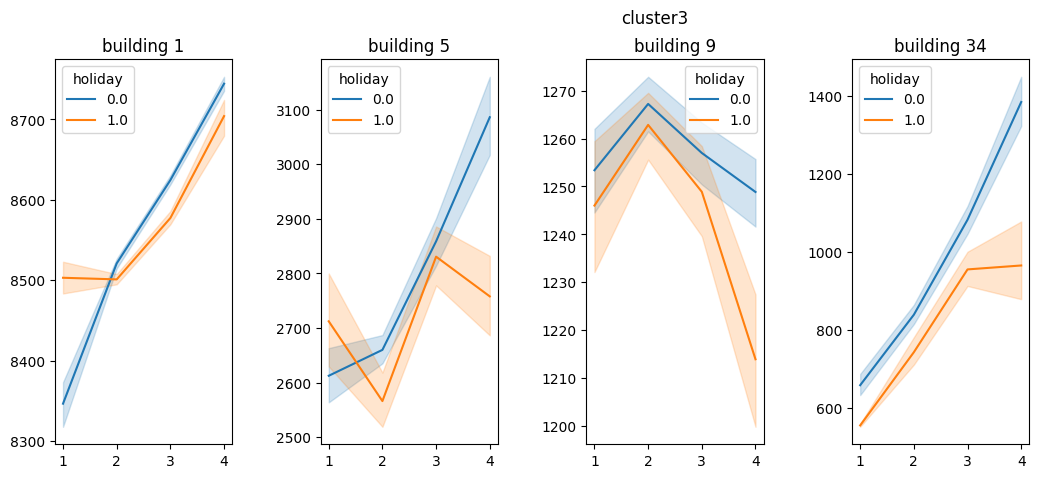

In [297]:
eda_df['THI'] = 9/5*eda_df['temp'] - 0.55*(1-eda_df['humid']/100)*(9/5*eda_df['temp']-26)+32
eda_df['THI_cat'] = pd.cut(eda_df['THI'], bins = [0, 68, 75, 80, 200], labels = [1,2,3,4])

for c in range(4):
    temp_1 = eda_df[eda_df.km_cluster == c]
    nums = np.unique(temp_1.num)
    n_nums = len(nums)
    fig = plt.figure(figsize = (16, 3*(n_nums//5 + 1)+2))
    plt.suptitle(f'cluster{c}')
    for i, num in enumerate(nums):
        temp_2 = temp_1[temp_1.num == num]
        plt.subplot(n_nums//5+1,5, i+1)
        sns.lineplot(data = temp_2, x='THI_cat', y='target', hue= 'holiday')
        plt.title(f'building {num}')
        plt.ylabel('')
        plt.xlabel('')
        plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

- 온도와 습도를 엮어 불쾌지수를 산출하여 건물 별로 영향력을 확인해봅시다.

- 쾌적(1) / 다소 쾌적(2) / 다소 불쾌(3) / 불쾌(4) 단계로 나뉩니다.

- 역시 불쾌지수(온도+습도)가 높을 수록 전력 사용량도 올라가는데 거의 모든 건물들이 이와 같은 패턴을 보여줍니다.

- 9번 건물은 불쾌지수가 일정량을 넘어버리면 오히려 전력 사용량이 내려가는데 특히 주말에 급격하게 작아지는데 아마도 건물을 닫아버리는 것 같습니다.
 
  사용량이 야간에만 있는 패턴의 건물인데 초콜렛같은 온도와 햇볕에 민감한 제품을 생산하는 공장일까요?

- 5번 건물도 주말에 불쾌지수 일정량을 넘으면 전력 사용량이 내려갑니다. 도대체 어떤 건물일까요?

###trainset.create()###

In [298]:
train.drop('date_time', axis=1, inplace=True)
train_x=train.drop('target', axis=1)
train_y=train[['target']]

- 학습용 세트를 생성해주는데 불필요한 날짜는 제거해줍니다

In [299]:
X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=1221)

# loss function : SMAPE 정의
# from sklearn.metrics import mean_absolute_error
def smape(true, pred): #MAE/MSE/MAPE/SMAPE/RMASSE
    true = np.array(true)  # np.array로 바꿔야 에러 없음
    pred = np.array(pred)
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))  # *2 , *100은 상수이므로 생략
    #return np.mean((np.abs(true-pred))/(np.abs(true) )) #mape
    # return np.mean((np.abs(true - pred)) ) #mae

SMAPE = make_scorer(smape, greater_is_better=False)  # smape 값이 작아져야하므로 False
#MAPE = make_scorer(mape, greater_is_better=False)
# MAE = make_scorer(mae, greater_is_better = False)
# = make_scorer(mse, greater_is_better = False)
# = make_scorer(rmsse, greater_is_better = False)

#Validation function
n_folds = 5

In [309]:
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

model_gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber')


model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_rf = RandomForestRegressor(n_estimators=3000,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10)

score = rmsle_cv(model_gb)
gb_score = score.mean()
print("GradientBoostingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


score = rmsle_cv(model_xgb)
xgb_score = score.mean()
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
lgb_score = score.mean()
print("LGBMRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


score = rmsle_cv(model_rf)
print("RandomForestRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

model_gb.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)

pred_gb = model_gb.predict(X_valid)
pred_xgb = model_xgb.predict(X_valid)
pred_lgb = model_lgb.predict(X_valid)


test_x = test.drop('date_time', axis=1)

total_weight = (1. / gb_score) + (1. / xgb_score) + (1. / lgb_score)
submission_y  = (pred_gb * (1. / gb_score) + pred_xgb * (1. / xgb_score) +  pred_lgb * (1. / lgb_score)) / total_weight
test['answer'] = submission_y
test['num_date_time'] = test.apply(lambda x: str(x['num']) +' '+ x['date_time'], axis=1)

submission = test[['num_date_time', 'answer']]
submission.to_csv('submission.csv', index=False)

In [305]:
score_df = pd.DataFrame({'model':['xgb'] + ['lgb'] + ['GradientBoostingRegressor'] + ['RandomForestRegressor'],
                         'building': list(range(1,61))*5,
                         'smape' : cat_best_scores + lgb_best_scores + enet_best_scores + ll_best_scores + svr_best_scores})
score_df['smape'] = score_df['smape'].abs()

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'smape', y = 'building', hue = 'model')

NameError: name 'cat_best_scores' is not defined

In [ ]:
print(smape(df_train['target'], oof))